# Predicción de Series Temporales NN - Embeddings

El artículo completo con la explicación detallada en el blog: http://www.aprendemachinelearning.com/

## Usaremos Keras y Tensorflow

Importamos las Librerías que vamos a utilizar

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

### Cargamos nuestro Dataset

In [48]:
df = pd.read_csv('time_series.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','unidades'])
df.head()

,unidades
fecha,
2017-01-02,236
2017-01-03,237
2017-01-04,290
2017-01-05,221
2017-01-07,128


In [49]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2017-01-02,236,0,1
2017-01-03,237,1,1
2017-01-04,290,2,1
2017-01-05,221,3,1
2017-01-07,128,5,1


In [50]:
df.describe()

,unidades,weekday,month
count,604.000000,604.000000,604.000000
mean,215.935430,2.644040,6.304636
std,75.050304,1.818674,3.312359
min,51.000000,0.000000,1.000000
25%,171.000000,1.000000,3.000000
50%,214.000000,3.000000,6.000000
75%,261.250000,4.000000,9.000000
max,591.000000,6.000000,12.000000


# Preprocesado de los datos

In [51]:
PASOS=7
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [52]:
# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df['weekday']
reframed['month']=df['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df['weekday'][i+8]
    reframed['month'].loc[contador]=df['month'][i+8]
    contador=contador+1
reframed.head()



/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month
0,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,3.0,1.0
1,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,4.0,1.0
2,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,5.0,1.0
3,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,0.0,1.0
4,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444,1.0,1.0


In [53]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,3.0,1.0,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
1,4.0,1.0,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
2,5.0,1.0,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
3,0.0,1.0,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
4,1.0,1.0,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444
5,2.0,1.0,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444,-0.303704
6,3.0,1.0,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444,-0.303704,-0.474074
7,4.0,1.0,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444,-0.303704,-0.474074,-0.459259
8,5.0,1.0,-0.607407,-0.522222,-0.644444,-0.344444,-0.303704,-0.474074,-0.459259,-0.488889
9,6.0,1.0,-0.522222,-0.644444,-0.344444,-0.303704,-0.474074,-0.459259,-0.488889,-0.622222


## Dividimos en set de Entrenamiento y Validación

In [54]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[595-30:595]
valid_target=target_data[595-30:595]

training_data = training_data[0:595]
target_data=target_data[0:595]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(595, 9) (595,) (30, 9) (30,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red Feedforward con Embeddings

### Tenemos como entradas 9 columnas (2 embeddings y 7 pasos)

In [55]:
def crear_modeloEmbeddings():
    emb_dias = 2 #tamanio profundidad de embeddings
    emb_meses = 4

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model


## Entrenamos nuestra máquina

In [56]:
EPOCHS=40

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dias (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
meses (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 2)         16          dias[0][0]                       
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 4)         52          meses[0][0]                      
__________________________________________________________________________________________________
concatenat

Epoch 38/40
595/595 [==============================] - 0s 59us/step - loss: 0.1076 - mean_squared_error: 0.0224 - val_loss: 0.0964 - val_mean_squared_error: 0.0201
Epoch 39/40
595/595 [==============================] - 0s 61us/step - loss: 0.1078 - mean_squared_error: 0.0225 - val_loss: 0.0953 - val_mean_squared_error: 0.0199
Epoch 40/40
595/595 [==============================] - 0s 64us/step - loss: 0.1080 - mean_squared_error: 0.0224 - val_loss: 0.0964 - val_mean_squared_error: 0.0204


## Visualizamos Resultados

30


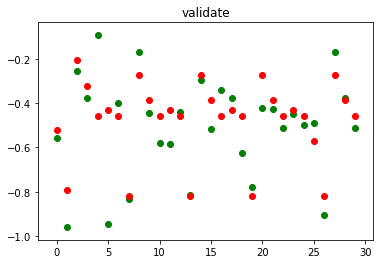

In [100]:
results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()


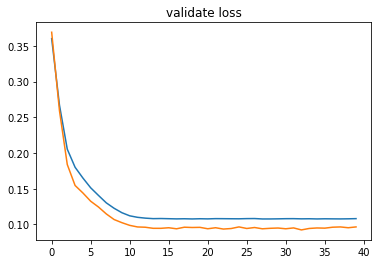

In [103]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

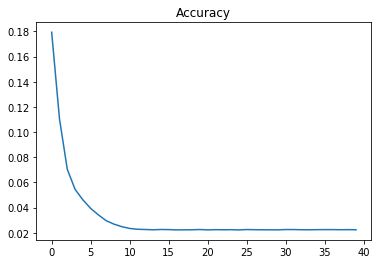

In [104]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [60]:
compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(12)

,real,prediccion,diferencia
0,171.000000,180.597778,-9.597778
1,62.000004,107.018166,-45.018162
2,252.000000,266.338470,-14.338470
3,220.000000,234.285080,-14.285080
4,296.000000,197.776123,98.223877
5,64.999992,204.157654,-139.157654
6,213.000000,197.658493,15.341507
7,95.999992,100.203423,-4.203430
8,275.000000,247.119278,27.880722
9,201.000000,216.487488,-15.487488


In [61]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,184.733337,193.536270,-8.802909
std,61.144787,47.120979,38.144459
min,62.000004,100.203423,-139.157654
25%,163.500000,197.658493,-22.024433
50%,194.500000,197.776123,-10.042633
75%,219.750000,216.487488,9.182810
max,296.000000,266.338470,98.223877


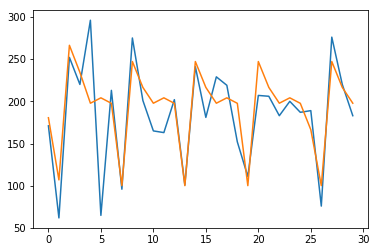

In [105]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Pronóstico

A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [63]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

,unidades,weekday,month
fecha,,,
2018-11-16,152,4,11
2018-11-17,111,5,11
2018-11-19,207,0,11
2018-11-20,206,1,11
2018-11-21,183,2,11
2018-11-22,200,3,11
2018-11-23,187,4,11
2018-11-24,189,5,11
2018-11-25,76,6,11


## Preparamos los datos para Test

In [65]:
# load dataset
values = ultimosDias['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=ultimosDias['weekday']
reframed['month']=ultimosDias['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=ultimosDias['weekday'][i+8]
    reframed['month'].loc[contador]=ultimosDias['month'][i+8]
    contador=contador+1
reframed.head()

reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)'] ]
reordenado.dropna(inplace=True)
reordenado

/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/jbagnato/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
0,6.0,11.0,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
1,0.0,11.0,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
2,1.0,11.0,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
3,2.0,11.0,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
4,3.0,11.0,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
5,4.0,11.0,0.24,0.11,0.13,-1.00,1.00,0.44,0.07


In [93]:
values = reordenado.values
x_test = values[5:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = reordenado.weekday[len(reordenado.index)-1]
ultDiaSemana

(1, 1, 9)
[[[ 4.         11.          0.24000001  0.11000001  0.13
   -1.          1.          0.44000006  0.06999993]]]


4.0

In [94]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i+2] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][0]=ultDiaSemana
    x_test[0][0][1]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

## Pronóstico para la "próxima semana"

In [95]:
results=[]
for i in range(7):
    dia=np.array([x_test[0][0][0]])
    mes=np.array([x_test[0][0][1]])
    valores=np.array([x_test[0][0][2:9]])
    parcial=model.predict([dia, mes, valores])
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)
    

pred 0 [[[ 4.         11.          0.24000001  0.11000001  0.13
   -1.          1.          0.44000006  0.06999993]]]
pred 1 [[[ 5.         12.          0.11000001  0.13       -1.
    1.          0.44000006  0.06999993 -0.43274945]]]
pred 2 [[[ 6.         12.          0.13       -1.          1.
    0.44000006  0.06999993 -0.43274945 -0.32928693]]]
pred 3 [[[ 0.         12.         -1.          1.          0.44000006
    0.06999993 -0.43274945 -0.32928693 -0.46238086]]]
pred 4 [[[ 1.         12.          1.          0.44000006  0.06999993
   -0.43274945 -0.32928693 -0.46238086 -0.76184267]]]
pred 5 [[[ 2.         12.          0.44000006  0.06999993 -0.43274945
   -0.32928693 -0.46238086 -0.76184267 -0.12789321]]]
pred 6 [[[ 3.         12.          0.06999993 -0.43274945 -0.32928693
   -0.46238086 -0.76184267 -0.12789321 -0.25119212]]]


## Re-Convertimos los resultados

In [96]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.43274945], dtype=float32), array([-0.32928693], dtype=float32), array([-0.46238086], dtype=float32), array([-0.76184267], dtype=float32), array([-0.12789321], dtype=float32), array([-0.25119212], dtype=float32), array([-0.32878956], dtype=float32)]


array([[132.72505699],
       [143.07130895],
       [129.76191632],
       [ 99.81573447],
       [163.21068175],
       [150.88079015],
       [143.12104605]])

## Visualizamos el pronóstico

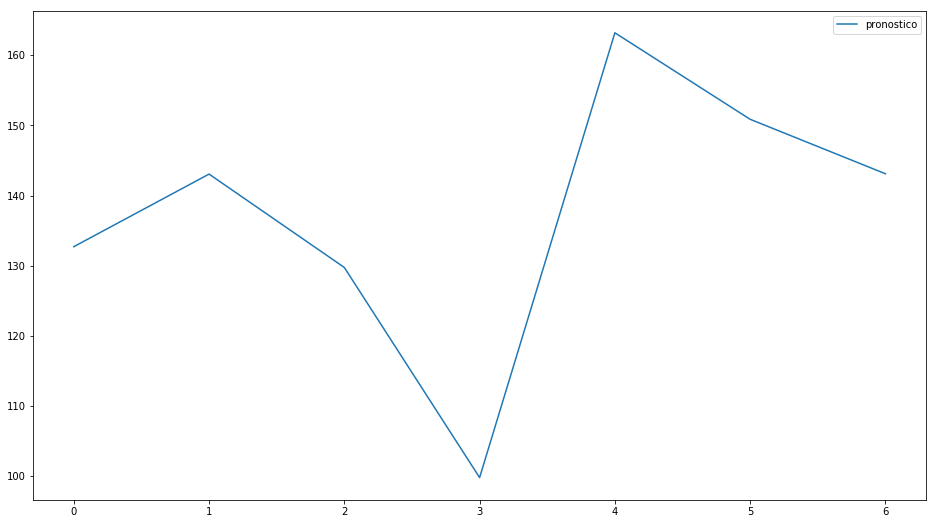

In [97]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico_embeddings.csv')

In [98]:
prediccion1SemanaDiciembre

,pronostico
0,132.725057
1,143.071309
2,129.761916
3,99.815734
4,163.210682
5,150.880790
6,143.121046


El artículo completo en www.aprendemachinelearning.com